In [1]:
'''
Usage:
1. Directory with data sets must be placed in directory named "input"
2. Input directory must be in the same directory as the .ipynb file with this sript
3. Inside each data set directory there must be three directories named: images, labels and masks.
4. Filenames of labels and masks files must be the same as image filename.
'''

'\nUsage:\n1. Directory with data sets must be placed in directory named "input"\n2. Input directory must be in the same directory as the .ipynb file with this sript\n3. Inside each data set directory there must be three directories named: images, labels and masks.\n4. Filenames of labels and masks files must be the same as image filename.\n'

In [2]:
import numpy as np
import os
import collections
import matplotlib.pyplot as plt
import skimage.future.graph as skigraph
import shutil
import pickle
import keras
import tensorflow as tf
import networkx as nx
import time
import sys
import shutil
from sklearn.metrics import confusion_matrix
from keras import backend as K

from kgcnn.literature.GCN import make_model
from kgcnn.utils.data import ragged_tensor_from_nested_numpy
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from kgcnn.utils.learning import LinearLearningRateScheduler
from PIL import Image, ImageOps
import radiomics
import numpy.ma as ma
import nrrd
import warnings
from collections import defaultdict
import logging

In [3]:
#!/usr/bin/env python
# coding: utf-8


import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import sys
from PIL import Image
import cv2
from datetime import datetime
import tensorflow as tf
import argparse

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, UpSampling2D, Input, concatenate
from keras import backend as K
#import tensorflow as tf
#from tensorflow.compat.v1 import ConfigProto
#from tensorflow.compat.v1 import InteractiveSession
from keras.callbacks import ModelCheckpoint
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance


data_gen_args = dict(
        rotation_range=10.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=10,
        zoom_range=0.2,
        horizontal_flip=False,
        vertical_flip=False,
        fill_mode='nearest'
)

def showOpencvImage(image, isGray=False):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap = 'gray')
    plt.show()

def get_augmented(
    X_train, 
    Y_train, 
    X_val=None,
    Y_val=None,
    batch_size=32, 
    seed=0, 
    data_gen_args = dict(
        rotation_range=10.,
        width_shift_range=0.02,
        height_shift_range=0.02,
        zca_whitening = False,
        zca_epsilon = 1e-6,
        shear_range=5,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest'
    )):


    # Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen_1 = ImageDataGenerator(**data_gen_args)
    Y_datagen_2 = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)
    Y_train_1 = Y_train[:,:,:,0:1]
    Y_train_2 = Y_train[:,:,:,1:2]
    Y_datagen_1.fit(Y_train_1, augment=True, seed=seed)
    Y_datagen_2.fit(Y_train_2, augment=True, seed=seed)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented_1 = Y_datagen_1.flow(Y_train_1, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented_2 = Y_datagen_2.flow(Y_train_2, batch_size=batch_size, shuffle=True, seed=seed)
    
    train_generator = zip(X_train_augmented, Y_train_augmented_1, Y_train_augmented_2)#, Y_train_augmented_3)
    return train_generator

def my_generator(
    X_train, 
    Y_train,
    train_gen,
    X_val=None,
    Y_val=None,
    batch_size=2, 
    seed=0, 
    data_gen_args = dict(
        rotation_range=10.,
        width_shift_range=0.02,
        height_shift_range=0.02,
        zca_whitening = False,
        zca_epsilon = 1e-6,
        shear_range=5,
        zoom_range=0.3,
        horizontal_flip=False,
        vertical_flip=False,
        fill_mode='nearest'
    )):
    while 1:
        sample_batch = next(train_gen)
        xx, yy1,yy2 = sample_batch
        yy = np.zeros((xx.shape[0],xx.shape[1],xx.shape[2],2),dtype=np.float32)
        yy[:,:,:,0:1] = yy1
        yy[:,:,:,1:2] = yy2
#        yy[:,:,:,6:7] = yy3
        yield (xx, yy)


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

def upsample_conv(filters, kernel_size, strides, padding):
    return Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)

def upsample_simple(filters, kernel_size, strides, padding):
    return UpSampling2D(strides)

def conv2d_block(
    inputs, 
    filters=16, 
    kernel_size=(3,3), 
    activation='tanh', 
#    kernel_initializer='he_normal', 
    kernel_initializer= 'glorot_uniform',
    padding='same'):
    
    c = Conv2D(filters, kernel_size, activation=activation, kernel_initializer=kernel_initializer, padding=padding) (inputs)
    c = Conv2D(filters, kernel_size, activation=activation, kernel_initializer=kernel_initializer, padding=padding) (c)
    return c

def my_custom_unet(
    input_shape,
    num_classes=1,
    upsample_mode='deconv', # 'deconv' or 'simple' 
    filters=16,
    num_layers=4,
    output_activation='softmax'): # 'sigmoid' or 'softmax'
    
    if upsample_mode=='deconv':
        upsample=upsample_conv
    else:
        upsample=upsample_simple

    # Build U-Net model
    inputs = Input(input_shape)
    x = inputs   

    down_layers = []
    for l in range(num_layers):
        x = conv2d_block(inputs=x, filters=filters)
        down_layers.append(x)
        x = MaxPooling2D((2, 2)) (x)
        filters = filters*2 # double the number of filters with each layer

    x = conv2d_block(inputs=x, filters=196)


    for conv in reversed(down_layers):        
        filters //= 2 # decreasing number of filters with each layer 
        x = upsample(filters, (2, 2), strides=(2, 2), padding='same') (x)
        x = concatenate([x, conv])
        x = conv2d_block(inputs=x, filters=filters)
    
    outputs = Conv2D(num_classes, (1, 1), activation=output_activation) (x)    

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

def iou(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

def train_UNET(graphs_train, graphs_test):

    imgs_train = []
    for graph in graphs_train:
        imgs_train.append(f"/home/daniel/Praca inżynierska/DetectingInflammationsInImagesOfSacroiliacJoint/input/300_pixel_40_com/images/{graph.file_id}.bmp")

    masks = glob.glob("/home/daniel/Praca inżynierska/DetectingInflammationsInImagesOfSacroiliacJoint/input/300_pixel_40_com/masks/*.bmp")
    orgs = glob.glob("/home/daniel/Praca inżynierska/DetectingInflammationsInImagesOfSacroiliacJoint/input/300_pixel_40_com/images/*.bmp")

    masks.sort()
    orgs.sort()


    list_train = []
    list_test =  []

    for (i,image) in enumerate(orgs):
        for (j,value) in enumerate(imgs_train):
            if image == value:
                list_train.append(i)
                break
            elif j==len(imgs_train)-1:
                list_test.append(i)
                
    print("FFFFFFFFFF")
    print(len(list_train))
    print(len(list_test))
    print(len(masks))
    print(len(orgs))

    imgs_list = []
    masks_list = []

    size = (128,128)

    for image, mask in zip(orgs, masks):
        im = cv2.imread(image)
        im = im[:,:,0]
        imgs_list.append(im)

        im = cv2.imread(mask)
        im = im[:,:,0]

        imMask = np.zeros((im.shape[0],im.shape[1],2),dtype=np.float32)
        imMask[im == 0,0] = 1               #background
        imMask[im!=0,1] = 1                 #spine

        masks_list.append(imMask)



    imgs_np = np.asarray(imgs_list)
    masks_np = np.asarray(masks_list)
    print(imgs_np.shape, masks_np.shape)

    weights = np.ones((2),dtype=np.float32)
    for i in range(0,2):
        weights[i] = 1/(np.sum(masks_np[:,:,:,i])/(masks_np.shape[0]*masks_np.shape[1]*masks_np.shape[2]))

    w = sum(weights)
    weights = weights/w

    print(weights)

    print(imgs_np.max(), masks_np.max())
    x = np.asarray(imgs_np, dtype=np.float32)
    y = np.asarray(masks_np, dtype=np.float32)
    print(x.max(), y.max())
    print(x.shape, y.shape)
    y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 2)
    print(x.shape, y.shape)
    x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
    print(x.shape, y.shape)

    list_val = list_train[:int(0.2*len(list_train))]
    list_train = list_train[int(0.2*len(list_train)):]

    print(list_train)
    print(list_val)
    print(list_test)

    x_train = x[list_train]
    x_val = x[list_val]
    x_test = x[list_test]

    y_train = y[list_train]
    y_val = y[list_val]
    y_test = y[list_test]

    print("x_train: ", x_train.shape)
    print("y_train: ", y_train.shape)
    print("x_val: ", x_val.shape)
    print("y_val: ", y_val.shape)
    print("x_test: ", x_test.shape)
    print("y_test: ", y_test.shape)

    input_shape = x_train[0].shape

    model = my_custom_unet(
        input_shape,
        num_classes=2,
        filters=64,
        output_activation='softmax',
        num_layers=4  
    )

    model_filename = 'segm_ALL_' + '.h5'

    callback_checkpoint = ModelCheckpoint(
        model_filename, 
        verbose=1, 
        monitor='val_loss', 
        save_best_only=True
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=0.0001), 
        loss = weighted_categorical_crossentropy(weights),
        metrics=[iou]
    )

    model.summary()

    train_gen = get_augmented(x_train, y_train, batch_size=2,data_gen_args=data_gen_args)
    generator = my_generator(x_train, y_train,train_gen, batch_size=2,data_gen_args=data_gen_args)

    history = model.fit_generator(
        generator,
        steps_per_epoch=30,
        epochs=1,
        validation_data=(x_val, y_val),
        callbacks=[callback_checkpoint]
    )


    model.load_weights(model_filename)
    os.makedirs(f"{OUTPUT_DIR_PATH}/generated_unet", exist_ok=True)
    for N in range(x_test.shape[0]):
        y_pred = model.predict(x_test[N:N+1])
        predictions = np.round(y_pred)
        for k in range(1,2):
            dum = predictions[0,:,:,k]*255
            cv2.imwrite(f'{OUTPUT_DIR_PATH}/generated_unet/{graphs_test[N].file_id}.png',dum)

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [4]:
# script parameterss
DATA_SET_DIR_NAMES = ["300_pixel_5_com", "300_pixel_10_com", "300_pixel_15_com", "300_pixel_20_com", "300_pixel_25_com", "300_pixel_30_com", "300_pixel_35_com", "300_pixel_40_com"]
PYRADIOMICS_FEATURES = [
    "original_firstorder_Mean",
    "original_firstorder_Variance",
    "original_glcm_ClusterTendency",
    "original_glcm_Correlation",
    "original_ngtdm_Contrast",
    "original_glrlm_RunEntropy",
    "original_gldm_DependenceEntropy",
    "original_gldm_SmallDependenceEmphasis",
    "original_glrlm_GrayLevelNonUniformity",
    "original_ngtdm_Busyness",
    "original_glszm_ZoneEntropy",
    "original_glszm_SizeZoneNonUniformity"
]
WHITE_SUPERPIXEL_LABEL_TRESHOLD = 0.65

# globals


#configuration
logger = logging.getLogger("radiomics")
logger.setLevel(logging.ERROR)

In [5]:
# utils
def save_object(filename, obj):
    obj_file = open(filename, "wb")
    pickle.dump(obj, obj_file)
    obj_file.close()
    
def load_object(filename):
    obj_file = open(filename, "rb")
    obj = pickle.load(obj_file)
    obj_file.close()
    
    return obj

class Graph:
    def __init__(self, file_id, rag, image, superpixels_labels, mask):
        self.file_id = file_id
        self.rag = rag
        self.image = image
        self.superpixels_labels = superpixels_labels
        self.mask = mask

class Subgraph:
    def __init__(self, rag, graph, middle_superpixel_label, label):
        self.rag = rag
        self.graph = graph
        self.middle_superpixel_label = middle_superpixel_label
        self.label = label
        self.unnormalized_edge_indices = None
        self.normalized_edge_indices = None
        self.edges = None
        self.nodes = None
        
def assign_labels(graph):
    white_pixels_count = defaultdict(int)
    total_pixels_count = defaultdict(int)
    
    for (i, row) in enumerate(graph.superpixels_labels):
        for (j, superpixel_label) in enumerate(row):
            total_pixels_count[superpixel_label] += 1
            if graph.mask[i][j] == 1:
                white_pixels_count[superpixel_label] += 1
      
    for node in graph.rag:
        graph.rag.nodes[node]['label'] = 1.0 if white_pixels_count[node] / total_pixels_count[node] >= WHITE_SUPERPIXEL_LABEL_TRESHOLD else 0.0
            
            
def assign_features(graph):
    unique_superpixels_labels = np.unique(graph.superpixels_labels)
    
    for superpixel_label in unique_superpixels_labels:
        superpixel_label_mask = (graph.superpixels_labels == superpixel_label).astype(int)
        NRRD_DIRECTORY_PATH = f"{OUTPUT_DIR_PATH}/nrrd"
        NRRD_ITEM_DIRECTORY_PATH = f"{NRRD_DIRECTORY_PATH}/{graph.file_id}"
        os.makedirs(NRRD_ITEM_DIRECTORY_PATH, exist_ok=True)
        
        os.makedirs(f"{NRRD_ITEM_DIRECTORY_PATH}", exist_ok=True)
        nrrd.write(f"{NRRD_ITEM_DIRECTORY_PATH}/{superpixel_label}_image.nrrd", graph.image)
        nrrd.write(f"{NRRD_ITEM_DIRECTORY_PATH}/{superpixel_label}_superpixel_label_mask.nrrd", superpixel_label_mask)
        nrrd_image_path = os.path.join(f"{NRRD_ITEM_DIRECTORY_PATH}", str(superpixel_label) + "_image.nrrd")
        nrrd_superpixel_label_mask_path = os.path.join(f"{NRRD_ITEM_DIRECTORY_PATH}", str(superpixel_label) + "_superpixel_label_mask.nrrd")
        
        extractor = radiomics.featureextractor.RadiomicsFeatureExtractor(minimumROIDimensions=1)
        result = extractor.execute(nrrd_image_path, nrrd_superpixel_label_mask_path)  

            
        for feature in PYRADIOMICS_FEATURES:
            graph.rag.nodes[superpixel_label][feature] = result[feature]
    
def process_images():
    filenames = os.listdir(IMAGES_DIR_PATH)
    os.makedirs(f"{OUTPUT_DIR_PATH}/expected", exist_ok=True)
    graphs = list()
        
    for (file_count, filename) in enumerate(filenames, start=1):
        print(f"Processing files: {file_count}/{len(filenames)}")
        
        file_id = os.path.splitext(filename)[0]
        
        try:
            image = np.array(ImageOps.grayscale(Image.open(f"{IMAGES_DIR_PATH}/{filename}")))
            mask = np.array(ImageOps.grayscale(Image.open(f"{MASKS_DIR_PATH}/{file_id}.bmp")))
            superpixels_labels = np.fromfile(f"{SUPERPIXELS_LABELS_DIR_PATH}/{file_id}.dat", dtype=np.dtype((np.int32, image.shape)))[0]
        except FileNotFoundError as error: 
            print(error)
            
        rag = skigraph.rag_mean_color(image, superpixels_labels)
        graphs.append(Graph(file_id, rag, image, superpixels_labels, mask))
        assign_labels(graphs[-1])
        assign_features(graphs[-1])
        
        expected = Image.fromarray((mask*255).astype(np.uint8))
        expected.save(f"{OUTPUT_DIR_PATH}/expected/{file_id}.png")
        
    print("All files have been processed")
    
    return graphs

def split_into_subgraphs(graphs):
    subgraphs = []
    for graph in graphs:
        for node in graph.rag.nodes:
            nodes = [neighbor for neighbor in graph.rag.neighbors(node)] + [node]
            rag = graph.rag.subgraph(nodes)
            label = graph.rag.nodes[node]['label']
            subgraphs.append(Subgraph(rag, graph, node, label))
            
    return subgraphs

def normalize_edge_indices(edge_indices):
    flat_list = [node for edge_index in edge_indices for node in edge_index]            
    flat_list.sort()
    flat_list = list(dict.fromkeys(flat_list))
    change = {key:value for (value, key) in enumerate(flat_list)}
    result = [[change[edge_index[0]], change[edge_index[1]]] for edge_index in edge_indices] 
    
    return result

def prepare_data(subgraphs):
    nodes = []
    edge_indices = []
    edges = []
    labels = []
    
    for subgraph in subgraphs:
        node_features = []
        
        for node in subgraph.rag.nodes:
            node_features.append([subgraph.rag.nodes[node][feature] for feature in PYRADIOMICS_FEATURES])
            
        nodes.append(node_features)
        edges.append([[1.0] for edge in subgraph.rag.edges.data()])
        unnormalized_edge_indices = [list(index) for index in subgraph.rag.edges]
        edge_indices.append(normalize_edge_indices(unnormalized_edge_indices))
        labels.append(subgraph.label)
        
        subgraph.nodes = nodes[-1]
        subgraph.unnormalized_edge_indices = unnormalized_edge_indices
        subgraph.normalized_edge_indices = edge_indices[-1]
        subgraph.edges = edges[-1]

    return nodes, edge_indices, edges, np.array(labels)

def generate_segmented_images_from_predictions(subgraphs, predictions):
    predicted_images = {}
    os.makedirs(f"{OUTPUT_DIR_PATH}/generated", exist_ok=True)

    for (prediction_count, subgraph) in enumerate(subgraphs):
        if subgraph.graph.file_id not in predicted_images:
            predicted_images[subgraph.graph.file_id] = np.copy(subgraph.graph.superpixels_labels)
        predicted_images[subgraph.graph.file_id][predicted_images[subgraph.graph.file_id] == subgraph.middle_superpixel_label] = predictions[prediction_count] - 2

    for file_id in predicted_images.keys():
        predicted_images[file_id][predicted_images[file_id] == -1] = 255
        predicted_images[file_id][predicted_images[file_id] == -2] = 0
        generated = Image.fromarray(predicted_images[file_id].astype(np.uint8))
        generated.save(f"{OUTPUT_DIR_PATH}/generated/{file_id}.png")

def compute_dice_coefficient(expected, generated):      
    expected[expected!=0] = 1
    generated[generated!=0] = 1
    intersection = expected*generated
    size = len(expected)*len(expected[0])

    return np.sum(intersection)/size

def compute_dice_coefficients_for_test_set(graphs_test, output_info_file):
    output_info_file.write(f"\t\tGCN\t\tUNET\n")
    for graph in graphs_test:
        expected = np.array(ImageOps.grayscale(Image.open(f"{OUTPUT_DIR_PATH}/expected/{graph.file_id}.png")))
        generated_unet = np.array(ImageOps.grayscale(Image.open(f"{OUTPUT_DIR_PATH}/generated_unet/{graph.file_id}.png")))
        generated = np.array(ImageOps.grayscale(Image.open(f"{OUTPUT_DIR_PATH}/generated/{graph.file_id}.png")))
        dice_coefficient = compute_dice_coefficient(expected, generated)
        dice_coefficient_unet = compute_dice_coefficient(expected, generated_unet)
        output_info_file.write(f"{graph.file_id}\t{str(dice_coefficient)}\t{str(dice_coefficient_unet)}\n")

        
def train_GCN(graphs, output_info_file, graphs_train, graphs_test):
    subgraphs_train = split_into_subgraphs(graphs_train)
    subgraphs_test = split_into_subgraphs(graphs_test)

    nodes_train, edge_indices_train, edges_train, labels_train =  prepare_data(subgraphs_train)
    nodes_test, edge_indices_test, edges_test, labels_test =  prepare_data(subgraphs_test)

    nodes_train = ragged_tensor_from_nested_numpy(nodes_train)
    edges_train = ragged_tensor_from_nested_numpy(edges_train)
    edge_indices_train = ragged_tensor_from_nested_numpy(edge_indices_train)

    nodes_test = ragged_tensor_from_nested_numpy(nodes_test)
    edges_test = ragged_tensor_from_nested_numpy(edges_test)
    edge_indices_test = ragged_tensor_from_nested_numpy(edge_indices_test)

    xtrain = nodes_train, edges_train, edge_indices_train
    xtest = nodes_test, edges_test, edge_indices_test
    ytrain = labels_train
    ytest = labels_test
    print([x.shape for x in xtrain])
    print([x.shape for x in xtest])
    print(ytrain.shape, ytest.shape)
    output_info_file.write(f"nodes_train: {xtrain[0].shape}\n")
    output_info_file.write(f"edges_train: {xtrain[1].shape}\n")
    output_info_file.write(f"edge_indices_train: {xtrain[2].shape}\n")
    output_info_file.write(f"labels_train: {ytrain.shape}\n")
    output_info_file.write(f"nodes_test: {xtest[0].shape}\n")
    output_info_file.write(f"edges_test: {xtest[1].shape}\n")
    output_info_file.write(f"edge_indices_test: {xtest[2].shape}\n")
    output_info_file.write(f"labels_test: {ytest.shape}\n")
    
    if os.path.exists(f"{SAVED_OBJECTS_DIR_PATH}/model"):
        model = keras.models.load_model(f"{SAVED_OBJECTS_DIR_PATH}/model")
    else:
        model = make_model(
        name = "GCN",
        inputs = [{'shape': (None, 12), 'name': "node_attributes", 'dtype': 'float32', 'ragged': True},
                {'shape': (None, 1), 'name': "edge_attributes", 'dtype': 'float32', 'ragged': True},
                {'shape': (None, 2), 'name': "edge_indices", 'dtype': 'int64', 'ragged': True}],
        input_embedding = {"node": {"input_dim": 55, "output_dim": 64},
                           "edge": {"input_dim": 10, "output_dim": 64}},
        output_embedding =  'graph',
        output_mlp = {"use_bias": [True, True, False], "units": [140, 70, 1],
                    "activation": ['relu', 'relu', 'sigmoid']},
        gcn_args = {"units": 64, "use_bias": True, "activation": 'relu', "pooling_method": 'mean', 
                    "normalize_by_weights": False},
        depth = 1
        )

        learning_rate_start = 1e-3
        learning_rate_stop = 1e-4
        epo = 150
        epomin = 100
        epostep = 10

        optimizer = tf.keras.optimizers.Adam(lr=learning_rate_start)
        cbks = LinearLearningRateScheduler(learning_rate_start, learning_rate_stop, epomin, epo)
        model.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      weighted_metrics=['accuracy'])
        print(model.summary())

        start = time.process_time()
        hist = model.fit(xtrain, ytrain,
                         epochs=epo,
                         batch_size=32,
                         callbacks=[cbks],
                         validation_freq=epostep,
                         validation_data=(xtest, ytest),
                         verbose=2
                         )
        stop = time.process_time()
        print("Print Time for taining: ", stop - start)

        trainlossall = np.array(hist.history['accuracy'])
        testlossall = np.array(hist.history['val_accuracy'])
        acc_valid = testlossall[-1]

        plt.figure()
        plt.plot(np.arange(trainlossall.shape[0]), trainlossall, label='Training ACC', c='blue')
        plt.plot(np.arange(epostep, epo + epostep, epostep), testlossall, label='Test ACC', c='red')
        plt.scatter([trainlossall.shape[0]], [acc_valid], label="{0:0.4f} ".format(acc_valid), c='red')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Interaction Network Loss')
        plt.legend(loc='upper right', fontsize='x-large')
        plt.savefig(f"{OUTPUT_DIR_PATH}/training_plot.png")
        plt.show()

        model.save(f"{SAVED_OBJECTS_DIR_PATH}/model")
    

    
    probability = model.predict(xtest)
    predictions = np.round(probability)
    print(confusion_matrix(ytest, predictions))
    output_info_file.write(np.array2string(confusion_matrix(ytest, predictions))+"\n")
    generate_segmented_images_from_predictions(subgraphs_test, predictions)
    compute_dice_coefficients_for_test_set(graphs_test,output_info_file)
    
def process_data_set(data_set_dir_name):
    
    # globals
    global DATA_DIR_PATH 
    global IMAGES_DIR_PATH
    global SUPERPIXELS_LABELS_DIR_PATH
    global MASKS_DIR_PATH
    global OUTPUT_DIR_PATH
    global SAVED_OBJECTS_DIR_PATH
    DATA_DIR_PATH = f"./input/{data_set_dir_name}"
    IMAGES_DIR_PATH = f"{DATA_DIR_PATH}/images"
    SUPERPIXELS_LABELS_DIR_PATH = f"{DATA_DIR_PATH}/superpixels_labels"
    MASKS_DIR_PATH = f"{DATA_DIR_PATH}/masks"
    OUTPUT_DIR_PATH = f"./output/{data_set_dir_name}"
    SAVED_OBJECTS_DIR_PATH = f"./saved_objects/{data_set_dir_name}"
    
    if os.path.exists(f"{OUTPUT_DIR_PATH}/info.txt"):
        os.remove(f"{OUTPUT_DIR_PATH}/info.txt")
    if os.path.exists(f"{OUTPUT_DIR_PATH}/training_plot.png"):
        os.remove(f"{OUTPUT_DIR_PATH}/training_plot.png")
    if os.path.exists(f"{OUTPUT_DIR_PATH}/generated"):
        shutil.rmtree(f"{OUTPUT_DIR_PATH}/generated")
    if os.path.exists(f"{OUTPUT_DIR_PATH}/generated_unet"):
        shutil.rmtree(f"{OUTPUT_DIR_PATH}/generated_unet")

    os.makedirs(f"{OUTPUT_DIR_PATH}", exist_ok=True)
    os.makedirs(f"{SAVED_OBJECTS_DIR_PATH}", exist_ok=True)
    os.makedirs(f"{OUTPUT_DIR_PATH}/generated")

    
    output_info_file = open(f"{OUTPUT_DIR_PATH}/info.txt","w+")
    output_info_file.write(f"data set: {data_set_dir_name}\n")
    
    if os.path.exists(f"{SAVED_OBJECTS_DIR_PATH}/graphs"):
        graphs = load_object(f"{SAVED_OBJECTS_DIR_PATH}/graphs")
    else:
        graphs = process_images()
        save_object(f"{SAVED_OBJECTS_DIR_PATH}/graphs", graphs)
        
    graphs_train, graphs_test = train_test_split(graphs, train_size=0.8, random_state=1)
    train_UNET(graphs_train, graphs_test)
    train_GCN(graphs, output_info_file, graphs_train, graphs_test)
    
    output_info_file.close()

FFFFFFFFFF
112
28
140
140
(140, 128, 128) (140, 128, 128, 2)
[0.22539543 0.77460456]
255 1.0
255.0 1.0
(140, 128, 128) (140, 128, 128, 2)
(140, 128, 128) (140, 128, 128, 2)
(140, 128, 128, 1) (140, 128, 128, 2)
[28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 42, 44, 45, 46, 47, 49, 50, 51, 52, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 73, 75, 77, 78, 79, 82, 83, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 101, 102, 104, 105, 106, 108, 109, 110, 111, 112, 114, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139]
[0, 2, 3, 4, 6, 7, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[1, 5, 8, 9, 17, 18, 35, 41, 43, 48, 53, 56, 65, 72, 74, 76, 80, 81, 84, 89, 99, 100, 103, 107, 113, 115, 118, 128]
x_train:  (90, 128, 128, 1)
y_train:  (90, 128, 128, 2)
x_val:  (22, 128, 128, 1)
y_val:  (22, 128, 128, 2)
x_test:  (28, 128, 128, 1)
y_test:  (28, 128, 128, 2)


/home/daniel/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

/home/daniel/.local/lib/python3.8/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


30/30 [==============================] - 35s 1s/step - loss: 0.2133 - iou: 0.4051 - val_loss: 0.1772 - val_iou: 0.4627

Epoch 00001: val_loss improved from inf to 0.17718, saving model to segm_ALL_.h5
[TensorShape([27903, None, 12]), TensorShape([27903, None, 1]), TensorShape([27903, None, 2])]
[TensorShape([7526, None, 12]), TensorShape([7526, None, 1]), TensorShape([7526, None, 2])]
(27903,) (7526,)
[[5593  329]
 [ 274 1330]]
Processing files: 1/140
Processing files: 2/140
Processing files: 3/140
Processing files: 4/140
Processing files: 5/140
Processing files: 6/140
Processing files: 7/140
Processing files: 8/140
Processing files: 9/140
Processing files: 10/140
Processing files: 11/140
Processing files: 12/140
Processing files: 13/140
Processing files: 14/140
Processing files: 15/140
Processing files: 16/140
Processing files: 17/140
Processing files: 18/140
Processing files: 19/140
Processing files: 20/140
Processing files: 21/140
Processing files: 22/140
Processing files: 23/140
Pr

/home/daniel/anaconda3/lib/python3.8/site-packages/radiomics/glcm.py:599: RuntimeWarning: invalid value encountered in sqrt
  imc2 = (1 - numpy.e ** (-2 * (HXY2 - HXY))) ** 0.5


Processing files: 40/140
Processing files: 41/140
Processing files: 42/140
Processing files: 43/140
Processing files: 44/140
Processing files: 45/140
Processing files: 46/140
Processing files: 47/140
Processing files: 48/140
Processing files: 49/140
Processing files: 50/140
Processing files: 51/140
Processing files: 52/140
Processing files: 53/140
Processing files: 54/140
Processing files: 55/140
Processing files: 56/140
Processing files: 57/140
Processing files: 58/140
Processing files: 59/140
Processing files: 60/140
Processing files: 61/140
Processing files: 62/140
Processing files: 63/140
Processing files: 64/140
Processing files: 65/140
Processing files: 66/140
Processing files: 67/140
Processing files: 68/140
Processing files: 69/140
Processing files: 70/140
Processing files: 71/140
Processing files: 72/140
Processing files: 73/140
Processing files: 74/140
Processing files: 75/140
Processing files: 76/140
Processing files: 77/140
Processing files: 78/140
Processing files: 79/140


/home/daniel/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_20[0][0]                  
____________________________________________________________________________________________

/home/daniel/.local/lib/python3.8/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


30/30 [==============================] - 30s 977ms/step - loss: 0.2458 - iou: 0.3364 - val_loss: 0.2219 - val_iou: 0.3591

Epoch 00001: val_loss improved from inf to 0.22191, saving model to segm_ALL_.h5
[TensorShape([28055, None, 12]), TensorShape([28055, None, 1]), TensorShape([28055, None, 2])]
[TensorShape([7583, None, 12]), TensorShape([7583, None, 1]), TensorShape([7583, None, 2])]
(28055,) (7583,)
INFO:kgcnn: Updated model kwargs:
{'depth': 1,
 'gcn_args': {'activation': 'relu',
              'has_unconnected': True,
              'is_sorted': False,
              'normalize_by_weights': False,
              'pooling_method': 'mean',
              'units': 64,
              'use_bias': True},
 'input_embedding': {'edge': {'input_dim': 10, 'output_dim': 64},
                     'node': {'input_dim': 55, 'output_dim': 64}},
 'inputs': [{'dtype': 'float32',
             'name': 'node_attributes',
             'ragged': True,
             'shape': (None, 12)},
            {'dtype':

/home/daniel/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_2/gcn/pooling_weighted_local_edges_1/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_2/gcn/pooling_weighted_local_edges_1/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model_2/gcn/pooling_weighted_local_edges_1/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/daniel/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_2/gcn/gather_nodes_outgoing_1/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model_2/gcn/gather_nodes_outgoing_1/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Ten

877/877 - 2s - loss: 0.5016 - accuracy: 0.8207
Epoch 2/150
877/877 - 2s - loss: 0.3180 - accuracy: 0.8618
Epoch 3/150
877/877 - 2s - loss: 0.2786 - accuracy: 0.8749
Epoch 4/150
877/877 - 2s - loss: 0.2673 - accuracy: 0.8771
Epoch 5/150
877/877 - 2s - loss: 0.2611 - accuracy: 0.8811
Epoch 6/150
877/877 - 2s - loss: 0.2567 - accuracy: 0.8834
Epoch 7/150
877/877 - 2s - loss: 0.2572 - accuracy: 0.8840
Epoch 8/150
877/877 - 2s - loss: 0.2508 - accuracy: 0.8857
Epoch 9/150
877/877 - 2s - loss: 0.2478 - accuracy: 0.8885
Epoch 10/150
877/877 - 2s - loss: 0.2501 - accuracy: 0.8891 - val_loss: 0.2385 - val_accuracy: 0.8944
Epoch 11/150
877/877 - 2s - loss: 0.2458 - accuracy: 0.8891
Epoch 12/150
877/877 - 2s - loss: 0.2407 - accuracy: 0.8907
Epoch 13/150
877/877 - 2s - loss: 0.2453 - accuracy: 0.8903
Epoch 14/150
877/877 - 2s - loss: 0.2428 - accuracy: 0.8900
Epoch 15/150
877/877 - 2s - loss: 0.2406 - accuracy: 0.8931
Epoch 16/150
877/877 - 2s - loss: 0.2404 - accuracy: 0.8915
Epoch 17/150
877/87

877/877 - 2s - loss: 0.2122 - accuracy: 0.9060
Epoch 130/150
877/877 - 2s - loss: 0.2127 - accuracy: 0.9047 - val_loss: 0.1955 - val_accuracy: 0.9145
Epoch 131/150
877/877 - 2s - loss: 0.2118 - accuracy: 0.9054
Epoch 132/150
877/877 - 2s - loss: 0.2114 - accuracy: 0.9048
Epoch 133/150
877/877 - 2s - loss: 0.2107 - accuracy: 0.9050
Epoch 134/150
877/877 - 2s - loss: 0.2098 - accuracy: 0.9064
Epoch 135/150
877/877 - 2s - loss: 0.2097 - accuracy: 0.9056
Epoch 136/150
877/877 - 2s - loss: 0.2102 - accuracy: 0.9056
Epoch 137/150
877/877 - 2s - loss: 0.2101 - accuracy: 0.9048
Epoch 138/150
877/877 - 2s - loss: 0.2082 - accuracy: 0.9062
Epoch 139/150
877/877 - 2s - loss: 0.2084 - accuracy: 0.9055
Epoch 140/150
877/877 - 2s - loss: 0.2075 - accuracy: 0.9069 - val_loss: 0.1912 - val_accuracy: 0.9151
Epoch 141/150
877/877 - 2s - loss: 0.2071 - accuracy: 0.9069
Epoch 142/150
877/877 - 2s - loss: 0.2069 - accuracy: 0.9067
Epoch 143/150
877/877 - 2s - loss: 0.2063 - accuracy: 0.9067
Epoch 144/150
8

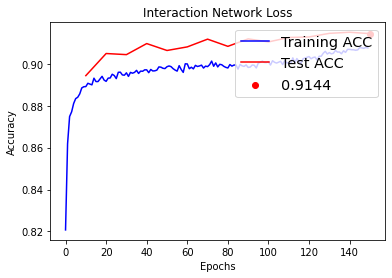

INFO:tensorflow:Assets written to: ./saved_objects/300_pixel_10_com/model/assets


INFO:tensorflow:Assets written to: ./saved_objects/300_pixel_10_com/model/assets


[[5559  349]
 [ 300 1375]]
Processing files: 1/140
Processing files: 2/140
Processing files: 3/140
Processing files: 4/140
Processing files: 5/140
Processing files: 6/140
Processing files: 7/140
Processing files: 8/140
Processing files: 9/140


/home/daniel/anaconda3/lib/python3.8/site-packages/radiomics/glcm.py:599: RuntimeWarning: invalid value encountered in sqrt
  imc2 = (1 - numpy.e ** (-2 * (HXY2 - HXY))) ** 0.5


Processing files: 10/140
Processing files: 11/140
Processing files: 12/140
Processing files: 13/140
Processing files: 14/140
Processing files: 15/140
Processing files: 16/140
Processing files: 17/140
Processing files: 18/140
Processing files: 19/140
Processing files: 20/140
Processing files: 21/140
Processing files: 22/140
Processing files: 23/140
Processing files: 24/140
Processing files: 25/140
Processing files: 26/140
Processing files: 27/140
Processing files: 28/140
Processing files: 29/140
Processing files: 30/140
Processing files: 31/140
Processing files: 32/140
Processing files: 33/140
Processing files: 34/140
Processing files: 35/140
Processing files: 36/140
Processing files: 37/140
Processing files: 38/140
Processing files: 39/140
Processing files: 40/140
Processing files: 41/140
Processing files: 42/140
Processing files: 43/140
Processing files: 44/140
Processing files: 45/140
Processing files: 46/140
Processing files: 47/140
Processing files: 48/140
Processing files: 49/140


/home/daniel/anaconda3/lib/python3.8/site-packages/radiomics/glcm.py:654: RuntimeWarning: invalid value encountered in sqrt
  MCC = numpy.sqrt(Q_eigenValue[:, :, -2])  # 2nd highest eigenvalue


Processing files: 100/140
Processing files: 101/140
Processing files: 102/140
Processing files: 103/140
Processing files: 104/140
Processing files: 105/140
Processing files: 106/140
Processing files: 107/140
Processing files: 108/140
Processing files: 109/140
Processing files: 110/140
Processing files: 111/140
Processing files: 112/140
Processing files: 113/140
Processing files: 114/140
Processing files: 115/140
Processing files: 116/140
Processing files: 117/140
Processing files: 118/140
Processing files: 119/140
Processing files: 120/140
Processing files: 121/140
Processing files: 122/140
Processing files: 123/140
Processing files: 124/140
Processing files: 125/140
Processing files: 126/140
Processing files: 127/140
Processing files: 128/140
Processing files: 129/140
Processing files: 130/140
Processing files: 131/140
Processing files: 132/140
Processing files: 133/140
Processing files: 134/140
Processing files: 135/140
Processing files: 136/140
Processing files: 137/140
Processing f

/home/daniel/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 128, 128, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_38[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_39[0][0]                  
____________________________________________________________________________________________

/home/daniel/.local/lib/python3.8/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


30/30 [==============================] - 33s 1s/step - loss: 0.2261 - iou: 0.3707 - val_loss: 0.2777 - val_iou: 0.6168

Epoch 00001: val_loss improved from inf to 0.27773, saving model to segm_ALL_.h5
[TensorShape([28131, None, 12]), TensorShape([28131, None, 1]), TensorShape([28131, None, 2])]
[TensorShape([7586, None, 12]), TensorShape([7586, None, 1]), TensorShape([7586, None, 2])]
(28131,) (7586,)
INFO:kgcnn: Updated model kwargs:
{'depth': 1,
 'gcn_args': {'activation': 'relu',
              'has_unconnected': True,
              'is_sorted': False,
              'normalize_by_weights': False,
              'pooling_method': 'mean',
              'units': 64,
              'use_bias': True},
 'input_embedding': {'edge': {'input_dim': 10, 'output_dim': 64},
                     'node': {'input_dim': 55, 'output_dim': 64}},
 'inputs': [{'dtype': 'float32',
             'name': 'node_attributes',
             'ragged': True,
             'shape': (None, 12)},
            {'dtype': 'f

/home/daniel/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_4/gcn_1/pooling_weighted_local_edges_2/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_4/gcn_1/pooling_weighted_local_edges_2/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model_4/gcn_1/pooling_weighted_local_edges_2/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/daniel/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_4/gcn_1/gather_nodes_outgoing_2/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model_4/gcn_1/gather_nodes_outgoing_2/Reshape:0", shape=(None, 64), dtype=float32), dense

880/880 - 3s - loss: 0.5053 - accuracy: 0.8191
Epoch 2/150
880/880 - 2s - loss: 0.3046 - accuracy: 0.8620
Epoch 3/150
880/880 - 2s - loss: 0.2729 - accuracy: 0.8734
Epoch 4/150
880/880 - 2s - loss: 0.2593 - accuracy: 0.8812
Epoch 5/150
880/880 - 2s - loss: 0.2593 - accuracy: 0.8818
Epoch 6/150
880/880 - 2s - loss: 0.2525 - accuracy: 0.8834
Epoch 7/150
880/880 - 2s - loss: 0.2505 - accuracy: 0.8862
Epoch 8/150
880/880 - 2s - loss: 0.2550 - accuracy: 0.8840
Epoch 9/150
880/880 - 2s - loss: 0.2467 - accuracy: 0.8878
Epoch 10/150
880/880 - 3s - loss: 0.2482 - accuracy: 0.8855 - val_loss: 0.2170 - val_accuracy: 0.9043
Epoch 11/150
880/880 - 2s - loss: 0.2454 - accuracy: 0.8876
Epoch 12/150
880/880 - 2s - loss: 0.2431 - accuracy: 0.8891
Epoch 13/150
880/880 - 2s - loss: 0.2420 - accuracy: 0.8893
Epoch 14/150
880/880 - 2s - loss: 0.2430 - accuracy: 0.8893
Epoch 15/150
880/880 - 2s - loss: 0.2398 - accuracy: 0.8901
Epoch 16/150
880/880 - 2s - loss: 0.2412 - accuracy: 0.8887
Epoch 17/150
880/88

880/880 - 2s - loss: 0.2123 - accuracy: 0.9022
Epoch 130/150
880/880 - 2s - loss: 0.2109 - accuracy: 0.9026 - val_loss: 0.1966 - val_accuracy: 0.9122
Epoch 131/150
880/880 - 2s - loss: 0.2112 - accuracy: 0.9028
Epoch 132/150
880/880 - 2s - loss: 0.2103 - accuracy: 0.9026
Epoch 133/150
880/880 - 2s - loss: 0.2103 - accuracy: 0.9041
Epoch 134/150
880/880 - 2s - loss: 0.2092 - accuracy: 0.9046
Epoch 135/150
880/880 - 2s - loss: 0.2094 - accuracy: 0.9044
Epoch 136/150
880/880 - 2s - loss: 0.2091 - accuracy: 0.9053
Epoch 137/150
880/880 - 2s - loss: 0.2083 - accuracy: 0.9047
Epoch 138/150
880/880 - 2s - loss: 0.2090 - accuracy: 0.9038
Epoch 139/150
880/880 - 2s - loss: 0.2079 - accuracy: 0.9044
Epoch 140/150
880/880 - 2s - loss: 0.2065 - accuracy: 0.9067 - val_loss: 0.2005 - val_accuracy: 0.9135
Epoch 141/150
880/880 - 2s - loss: 0.2075 - accuracy: 0.9052
Epoch 142/150
880/880 - 2s - loss: 0.2066 - accuracy: 0.9052
Epoch 143/150
880/880 - 2s - loss: 0.2058 - accuracy: 0.9044
Epoch 144/150
8

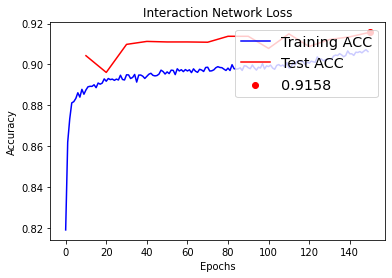

INFO:tensorflow:Assets written to: ./saved_objects/300_pixel_15_com/model/assets


INFO:tensorflow:Assets written to: ./saved_objects/300_pixel_15_com/model/assets


[[5476  392]
 [ 247 1471]]
Processing files: 1/140
Processing files: 2/140
Processing files: 3/140
Processing files: 4/140
Processing files: 5/140
Processing files: 6/140
Processing files: 7/140
Processing files: 8/140
Processing files: 9/140
Processing files: 10/140
Processing files: 11/140
Processing files: 12/140
Processing files: 13/140
Processing files: 14/140
Processing files: 15/140
Processing files: 16/140
Processing files: 17/140
Processing files: 18/140
Processing files: 19/140
Processing files: 20/140
Processing files: 21/140
Processing files: 22/140
Processing files: 23/140
Processing files: 24/140
Processing files: 25/140
Processing files: 26/140
Processing files: 27/140
Processing files: 28/140
Processing files: 29/140
Processing files: 30/140
Processing files: 31/140
Processing files: 32/140
Processing files: 33/140
Processing files: 34/140
Processing files: 35/140
Processing files: 36/140
Processing files: 37/140
Processing files: 38/140
Processing files: 39/140
Process

/home/daniel/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 128, 128, 64) 640         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_57[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 64, 64, 64)   0           conv2d_58[0][0]                  
____________________________________________________________________________________________

/home/daniel/.local/lib/python3.8/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


30/30 [==============================] - 33s 1s/step - loss: 0.2375 - iou: 0.3451 - val_loss: 0.1880 - val_iou: 0.4191

Epoch 00001: val_loss improved from inf to 0.18801, saving model to segm_ALL_.h5
[TensorShape([8833, None, 12]), TensorShape([8833, None, 1]), TensorShape([8833, None, 2])]
[TensorShape([2182, None, 12]), TensorShape([2182, None, 1]), TensorShape([2182, None, 2])]
(8833,) (2182,)
INFO:kgcnn: Updated model kwargs:
{'depth': 1,
 'gcn_args': {'activation': 'relu',
              'has_unconnected': True,
              'is_sorted': False,
              'normalize_by_weights': False,
              'pooling_method': 'mean',
              'units': 64,
              'use_bias': True},
 'input_embedding': {'edge': {'input_dim': 10, 'output_dim': 64},
                     'node': {'input_dim': 55, 'output_dim': 64}},
 'inputs': [{'dtype': 'float32',
             'name': 'node_attributes',
             'ragged': True,
             'shape': (None, 12)},
            {'dtype': 'float

/home/daniel/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_6/gcn_2/pooling_weighted_local_edges_3/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_6/gcn_2/pooling_weighted_local_edges_3/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model_6/gcn_2/pooling_weighted_local_edges_3/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/daniel/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_6/gcn_2/gather_nodes_outgoing_3/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model_6/gcn_2/gather_nodes_outgoing_3/Reshape:0", shape=(None, 64), dtype=float32), dense

277/277 - 1s - loss: 0.6277 - accuracy: 0.7683
Epoch 2/150
277/277 - 1s - loss: 0.4618 - accuracy: 0.7848
Epoch 3/150
277/277 - 1s - loss: 0.4147 - accuracy: 0.8027
Epoch 4/150
277/277 - 1s - loss: 0.3935 - accuracy: 0.8071
Epoch 5/150
277/277 - 1s - loss: 0.3733 - accuracy: 0.8159
Epoch 6/150
277/277 - 1s - loss: 0.3712 - accuracy: 0.8132
Epoch 7/150
277/277 - 1s - loss: 0.3630 - accuracy: 0.8224
Epoch 8/150
277/277 - 1s - loss: 0.3537 - accuracy: 0.8217
Epoch 9/150
277/277 - 1s - loss: 0.3384 - accuracy: 0.8288
Epoch 10/150
277/277 - 1s - loss: 0.3382 - accuracy: 0.8302 - val_loss: 0.3736 - val_accuracy: 0.8158
Epoch 11/150
277/277 - 1s - loss: 0.3407 - accuracy: 0.8244
Epoch 12/150
277/277 - 1s - loss: 0.3370 - accuracy: 0.8344
Epoch 13/150
277/277 - 1s - loss: 0.3355 - accuracy: 0.8310
Epoch 14/150
277/277 - 1s - loss: 0.3439 - accuracy: 0.8219
Epoch 15/150
277/277 - 1s - loss: 0.3397 - accuracy: 0.8275
Epoch 16/150
277/277 - 1s - loss: 0.3337 - accuracy: 0.8335
Epoch 17/150
277/27

277/277 - 1s - loss: 0.2541 - accuracy: 0.8747
Epoch 130/150
277/277 - 1s - loss: 0.2560 - accuracy: 0.8733 - val_loss: 0.2822 - val_accuracy: 0.8671
Epoch 131/150
277/277 - 1s - loss: 0.2539 - accuracy: 0.8774
Epoch 132/150
277/277 - 1s - loss: 0.2526 - accuracy: 0.8738
Epoch 133/150
277/277 - 1s - loss: 0.2509 - accuracy: 0.8739
Epoch 134/150
277/277 - 1s - loss: 0.2486 - accuracy: 0.8757
Epoch 135/150
277/277 - 1s - loss: 0.2501 - accuracy: 0.8765
Epoch 136/150
277/277 - 1s - loss: 0.2475 - accuracy: 0.8765
Epoch 137/150
277/277 - 1s - loss: 0.2467 - accuracy: 0.8777
Epoch 138/150
277/277 - 1s - loss: 0.2469 - accuracy: 0.8755
Epoch 139/150
277/277 - 1s - loss: 0.2450 - accuracy: 0.8767
Epoch 140/150
277/277 - 1s - loss: 0.2452 - accuracy: 0.8789 - val_loss: 0.2903 - val_accuracy: 0.8611
Epoch 141/150
277/277 - 1s - loss: 0.2422 - accuracy: 0.8790
Epoch 142/150
277/277 - 1s - loss: 0.2415 - accuracy: 0.8801
Epoch 143/150
277/277 - 1s - loss: 0.2442 - accuracy: 0.8784
Epoch 144/150
2

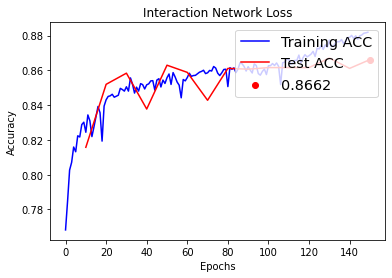

INFO:tensorflow:Assets written to: ./saved_objects/300_pixel_20_com/model/assets


INFO:tensorflow:Assets written to: ./saved_objects/300_pixel_20_com/model/assets


[[1509  148]
 [ 144  381]]
Processing files: 1/140
Processing files: 2/140
Processing files: 3/140
Processing files: 4/140
Processing files: 5/140
Processing files: 6/140
Processing files: 7/140
Processing files: 8/140
Processing files: 9/140
Processing files: 10/140
Processing files: 11/140
Processing files: 12/140
Processing files: 13/140
Processing files: 14/140
Processing files: 15/140


/home/daniel/anaconda3/lib/python3.8/site-packages/radiomics/glcm.py:599: RuntimeWarning: invalid value encountered in sqrt
  imc2 = (1 - numpy.e ** (-2 * (HXY2 - HXY))) ** 0.5


Processing files: 16/140
Processing files: 17/140
Processing files: 18/140
Processing files: 19/140
Processing files: 20/140
Processing files: 21/140
Processing files: 22/140
Processing files: 23/140
Processing files: 24/140
Processing files: 25/140
Processing files: 26/140
Processing files: 27/140
Processing files: 28/140
Processing files: 29/140
Processing files: 30/140
Processing files: 31/140
Processing files: 32/140
Processing files: 33/140
Processing files: 34/140
Processing files: 35/140
Processing files: 36/140
Processing files: 37/140
Processing files: 38/140
Processing files: 39/140
Processing files: 40/140
Processing files: 41/140
Processing files: 42/140
Processing files: 43/140
Processing files: 44/140
Processing files: 45/140
Processing files: 46/140
Processing files: 47/140
Processing files: 48/140
Processing files: 49/140
Processing files: 50/140
Processing files: 51/140
Processing files: 52/140
Processing files: 53/140
Processing files: 54/140
Processing files: 55/140


/home/daniel/anaconda3/lib/python3.8/site-packages/radiomics/glcm.py:654: RuntimeWarning: invalid value encountered in sqrt
  MCC = numpy.sqrt(Q_eigenValue[:, :, -2])  # 2nd highest eigenvalue


Processing files: 98/140
Processing files: 99/140
Processing files: 100/140
Processing files: 101/140
Processing files: 102/140
Processing files: 103/140
Processing files: 104/140
Processing files: 105/140
Processing files: 106/140
Processing files: 107/140
Processing files: 108/140
Processing files: 109/140
Processing files: 110/140
Processing files: 111/140
Processing files: 112/140
Processing files: 113/140
Processing files: 114/140
Processing files: 115/140
Processing files: 116/140
Processing files: 117/140
Processing files: 118/140
Processing files: 119/140
Processing files: 120/140
Processing files: 121/140
Processing files: 122/140
Processing files: 123/140
Processing files: 124/140
Processing files: 125/140
Processing files: 126/140
Processing files: 127/140
Processing files: 128/140
Processing files: 129/140
Processing files: 130/140
Processing files: 131/140
Processing files: 132/140
Processing files: 133/140
Processing files: 134/140
Processing files: 135/140
Processing fil

/home/daniel/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_76 (Conv2D)              (None, 128, 128, 64) 640         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_76[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 64, 64, 64)   0           conv2d_77[0][0]                  
____________________________________________________________________________________________

/home/daniel/.local/lib/python3.8/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


30/30 [==============================] - 33s 1s/step - loss: 0.2308 - iou: 0.3592 - val_loss: 0.1595 - val_iou: 0.5167

Epoch 00001: val_loss improved from inf to 0.15951, saving model to segm_ALL_.h5
[TensorShape([28417, None, 12]), TensorShape([28417, None, 1]), TensorShape([28417, None, 2])]
[TensorShape([7711, None, 12]), TensorShape([7711, None, 1]), TensorShape([7711, None, 2])]
(28417,) (7711,)
INFO:kgcnn: Updated model kwargs:
{'depth': 1,
 'gcn_args': {'activation': 'relu',
              'has_unconnected': True,
              'is_sorted': False,
              'normalize_by_weights': False,
              'pooling_method': 'mean',
              'units': 64,
              'use_bias': True},
 'input_embedding': {'edge': {'input_dim': 10, 'output_dim': 64},
                     'node': {'input_dim': 55, 'output_dim': 64}},
 'inputs': [{'dtype': 'float32',
             'name': 'node_attributes',
             'ragged': True,
             'shape': (None, 12)},
            {'dtype': 'f

/home/daniel/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_8/gcn_3/pooling_weighted_local_edges_4/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_8/gcn_3/pooling_weighted_local_edges_4/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model_8/gcn_3/pooling_weighted_local_edges_4/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/daniel/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_8/gcn_3/gather_nodes_outgoing_4/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model_8/gcn_3/gather_nodes_outgoing_4/Reshape:0", shape=(None, 64), dtype=float32), dense

889/889 - 3s - loss: 0.4553 - accuracy: 0.8256
Epoch 2/150
889/889 - 2s - loss: 0.3029 - accuracy: 0.8647
Epoch 3/150
889/889 - 2s - loss: 0.2757 - accuracy: 0.8769
Epoch 4/150
889/889 - 2s - loss: 0.2572 - accuracy: 0.8849
Epoch 5/150
889/889 - 2s - loss: 0.2534 - accuracy: 0.8868
Epoch 6/150
889/889 - 2s - loss: 0.2487 - accuracy: 0.8873
Epoch 7/150
889/889 - 2s - loss: 0.2470 - accuracy: 0.8897
Epoch 8/150
889/889 - 2s - loss: 0.2463 - accuracy: 0.8866
Epoch 9/150
889/889 - 2s - loss: 0.2403 - accuracy: 0.8909
Epoch 10/150
889/889 - 3s - loss: 0.2391 - accuracy: 0.8928 - val_loss: 0.1993 - val_accuracy: 0.9097
Epoch 11/150
889/889 - 2s - loss: 0.2350 - accuracy: 0.8949
Epoch 12/150
889/889 - 2s - loss: 0.2391 - accuracy: 0.8915
Epoch 13/150
889/889 - 2s - loss: 0.2384 - accuracy: 0.8936
Epoch 14/150
889/889 - 2s - loss: 0.2348 - accuracy: 0.8935
Epoch 15/150
889/889 - 2s - loss: 0.2302 - accuracy: 0.8957
Epoch 16/150
889/889 - 2s - loss: 0.2322 - accuracy: 0.8949
Epoch 17/150
889/88

889/889 - 2s - loss: 0.1953 - accuracy: 0.9107
Epoch 130/150
889/889 - 2s - loss: 0.1951 - accuracy: 0.9113 - val_loss: 0.1932 - val_accuracy: 0.9136
Epoch 131/150
889/889 - 2s - loss: 0.1946 - accuracy: 0.9127
Epoch 132/150
889/889 - 2s - loss: 0.1948 - accuracy: 0.9124
Epoch 133/150
889/889 - 2s - loss: 0.1924 - accuracy: 0.9129
Epoch 134/150
889/889 - 2s - loss: 0.1922 - accuracy: 0.9120
Epoch 135/150
889/889 - 2s - loss: 0.1924 - accuracy: 0.9113
Epoch 136/150
889/889 - 2s - loss: 0.1917 - accuracy: 0.9125
Epoch 137/150
889/889 - 2s - loss: 0.1914 - accuracy: 0.9121
Epoch 138/150
889/889 - 2s - loss: 0.1912 - accuracy: 0.9126
Epoch 139/150
889/889 - 2s - loss: 0.1907 - accuracy: 0.9135
Epoch 140/150
889/889 - 2s - loss: 0.1900 - accuracy: 0.9132 - val_loss: 0.1987 - val_accuracy: 0.9139
Epoch 141/150
889/889 - 2s - loss: 0.1888 - accuracy: 0.9133
Epoch 142/150
889/889 - 2s - loss: 0.1887 - accuracy: 0.9128
Epoch 143/150
889/889 - 2s - loss: 0.1882 - accuracy: 0.9137
Epoch 144/150
8

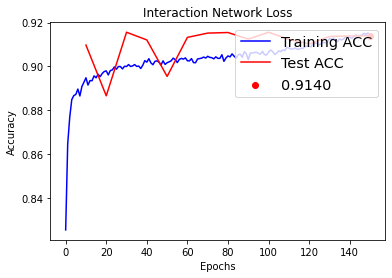

INFO:tensorflow:Assets written to: ./saved_objects/300_pixel_25_com/model/assets


INFO:tensorflow:Assets written to: ./saved_objects/300_pixel_25_com/model/assets


[[5594  376]
 [ 287 1454]]
Processing files: 1/140
Processing files: 2/140
Processing files: 3/140
Processing files: 4/140
Processing files: 5/140
Processing files: 6/140
Processing files: 7/140
Processing files: 8/140
Processing files: 9/140
Processing files: 10/140
Processing files: 11/140
Processing files: 12/140
Processing files: 13/140
Processing files: 14/140
Processing files: 15/140
Processing files: 16/140
Processing files: 17/140
Processing files: 18/140
Processing files: 19/140
Processing files: 20/140
Processing files: 21/140
Processing files: 22/140
Processing files: 23/140
Processing files: 24/140
Processing files: 25/140
Processing files: 26/140
Processing files: 27/140


/home/daniel/anaconda3/lib/python3.8/site-packages/radiomics/glcm.py:654: RuntimeWarning: invalid value encountered in sqrt
  MCC = numpy.sqrt(Q_eigenValue[:, :, -2])  # 2nd highest eigenvalue


Processing files: 28/140
Processing files: 29/140
Processing files: 30/140
Processing files: 31/140
Processing files: 32/140
Processing files: 33/140
Processing files: 34/140
Processing files: 35/140
Processing files: 36/140
Processing files: 37/140
Processing files: 38/140
Processing files: 39/140
Processing files: 40/140
Processing files: 41/140
Processing files: 42/140
Processing files: 43/140
Processing files: 44/140
Processing files: 45/140
Processing files: 46/140
Processing files: 47/140
Processing files: 48/140
Processing files: 49/140
Processing files: 50/140
Processing files: 51/140
Processing files: 52/140
Processing files: 53/140
Processing files: 54/140
Processing files: 55/140
Processing files: 56/140
Processing files: 57/140
Processing files: 58/140
Processing files: 59/140
Processing files: 60/140
Processing files: 61/140
Processing files: 62/140
Processing files: 63/140
Processing files: 64/140
Processing files: 65/140
Processing files: 66/140
Processing files: 67/140


/home/daniel/anaconda3/lib/python3.8/site-packages/radiomics/glcm.py:599: RuntimeWarning: invalid value encountered in sqrt
  imc2 = (1 - numpy.e ** (-2 * (HXY2 - HXY))) ** 0.5


Processing files: 106/140
Processing files: 107/140
Processing files: 108/140
Processing files: 109/140
Processing files: 110/140
Processing files: 111/140
Processing files: 112/140
Processing files: 113/140
Processing files: 114/140
Processing files: 115/140
Processing files: 116/140
Processing files: 117/140
Processing files: 118/140
Processing files: 119/140
Processing files: 120/140
Processing files: 121/140
Processing files: 122/140
Processing files: 123/140
Processing files: 124/140
Processing files: 125/140
Processing files: 126/140
Processing files: 127/140
Processing files: 128/140
Processing files: 129/140
Processing files: 130/140
Processing files: 131/140
Processing files: 132/140
Processing files: 133/140
Processing files: 134/140
Processing files: 135/140
Processing files: 136/140
Processing files: 137/140
Processing files: 138/140
Processing files: 139/140
Processing files: 140/140
All files have been processed
FFFFFFFFFF
112
28
140
140
(140, 128, 128) (140, 128, 128, 2)

/home/daniel/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 128, 128, 64) 640         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_95[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, 64, 64, 64)   0           conv2d_96[0][0]                  
____________________________________________________________________________________________

/home/daniel/.local/lib/python3.8/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


30/30 [==============================] - 30s 967ms/step - loss: 0.2372 - iou: 0.3493 - val_loss: 0.1971 - val_iou: 0.3826

Epoch 00001: val_loss improved from inf to 0.19709, saving model to segm_ALL_.h5
[TensorShape([28560, None, 12]), TensorShape([28560, None, 1]), TensorShape([28560, None, 2])]
[TensorShape([7773, None, 12]), TensorShape([7773, None, 1]), TensorShape([7773, None, 2])]
(28560,) (7773,)
INFO:kgcnn: Updated model kwargs:
{'depth': 1,
 'gcn_args': {'activation': 'relu',
              'has_unconnected': True,
              'is_sorted': False,
              'normalize_by_weights': False,
              'pooling_method': 'mean',
              'units': 64,
              'use_bias': True},
 'input_embedding': {'edge': {'input_dim': 10, 'output_dim': 64},
                     'node': {'input_dim': 55, 'output_dim': 64}},
 'inputs': [{'dtype': 'float32',
             'name': 'node_attributes',
             'ragged': True,
             'shape': (None, 12)},
            {'dtype':

/home/daniel/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_10/gcn_4/pooling_weighted_local_edges_5/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_10/gcn_4/pooling_weighted_local_edges_5/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model_10/gcn_4/pooling_weighted_local_edges_5/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/daniel/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_10/gcn_4/gather_nodes_outgoing_5/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model_10/gcn_4/gather_nodes_outgoing_5/Reshape:0", shape=(None, 64), dtype=float32), 

893/893 - 2s - loss: 0.4233 - accuracy: 0.8315
Epoch 2/150
893/893 - 2s - loss: 0.2949 - accuracy: 0.8664
Epoch 3/150
893/893 - 2s - loss: 0.2646 - accuracy: 0.8793
Epoch 4/150
893/893 - 2s - loss: 0.2570 - accuracy: 0.8831
Epoch 5/150
893/893 - 2s - loss: 0.2540 - accuracy: 0.8853
Epoch 6/150
893/893 - 2s - loss: 0.2484 - accuracy: 0.8879
Epoch 7/150
893/893 - 2s - loss: 0.2483 - accuracy: 0.8884
Epoch 8/150
893/893 - 2s - loss: 0.2433 - accuracy: 0.8904
Epoch 9/150
893/893 - 2s - loss: 0.2416 - accuracy: 0.8918
Epoch 10/150
893/893 - 2s - loss: 0.2407 - accuracy: 0.8904 - val_loss: 0.2225 - val_accuracy: 0.9039
Epoch 11/150
893/893 - 2s - loss: 0.2383 - accuracy: 0.8936
Epoch 12/150
893/893 - 2s - loss: 0.2372 - accuracy: 0.8940
Epoch 13/150
893/893 - 2s - loss: 0.2356 - accuracy: 0.8925
Epoch 14/150
893/893 - 2s - loss: 0.2339 - accuracy: 0.8937
Epoch 15/150
893/893 - 2s - loss: 0.2344 - accuracy: 0.8952
Epoch 16/150
893/893 - 2s - loss: 0.2320 - accuracy: 0.8967
Epoch 17/150
893/89

893/893 - 2s - loss: 0.1956 - accuracy: 0.9109
Epoch 130/150
893/893 - 2s - loss: 0.1948 - accuracy: 0.9114 - val_loss: 0.1932 - val_accuracy: 0.9125
Epoch 131/150
893/893 - 2s - loss: 0.1940 - accuracy: 0.9100
Epoch 132/150
893/893 - 2s - loss: 0.1938 - accuracy: 0.9101
Epoch 133/150
893/893 - 2s - loss: 0.1929 - accuracy: 0.9103
Epoch 134/150
893/893 - 2s - loss: 0.1926 - accuracy: 0.9115
Epoch 135/150
893/893 - 2s - loss: 0.1917 - accuracy: 0.9117
Epoch 136/150
893/893 - 2s - loss: 0.1918 - accuracy: 0.9112
Epoch 137/150
893/893 - 2s - loss: 0.1925 - accuracy: 0.9114
Epoch 138/150
893/893 - 2s - loss: 0.1904 - accuracy: 0.9119
Epoch 139/150
893/893 - 2s - loss: 0.1899 - accuracy: 0.9123
Epoch 140/150
893/893 - 2s - loss: 0.1930 - accuracy: 0.9128 - val_loss: 0.2076 - val_accuracy: 0.9090
Epoch 141/150
893/893 - 2s - loss: 0.1889 - accuracy: 0.9126
Epoch 142/150
893/893 - 2s - loss: 0.1887 - accuracy: 0.9133
Epoch 143/150
893/893 - 2s - loss: 0.1874 - accuracy: 0.9133
Epoch 144/150
8

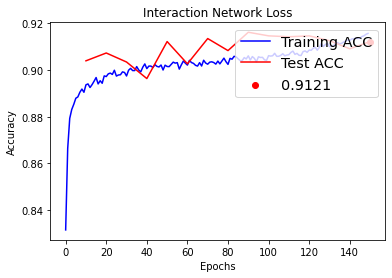

INFO:tensorflow:Assets written to: ./saved_objects/300_pixel_30_com/model/assets


INFO:tensorflow:Assets written to: ./saved_objects/300_pixel_30_com/model/assets


[[5601  420]
 [ 263 1489]]
Processing files: 1/140
Processing files: 2/140
Processing files: 3/140
Processing files: 4/140
Processing files: 5/140


/home/daniel/anaconda3/lib/python3.8/site-packages/radiomics/glcm.py:654: RuntimeWarning: invalid value encountered in sqrt
  MCC = numpy.sqrt(Q_eigenValue[:, :, -2])  # 2nd highest eigenvalue


Processing files: 6/140
Processing files: 7/140
Processing files: 8/140
Processing files: 9/140
Processing files: 10/140
Processing files: 11/140
Processing files: 12/140
Processing files: 13/140
Processing files: 14/140
Processing files: 15/140
Processing files: 16/140
Processing files: 17/140
Processing files: 18/140
Processing files: 19/140
Processing files: 20/140
Processing files: 21/140
Processing files: 22/140
Processing files: 23/140
Processing files: 24/140
Processing files: 25/140
Processing files: 26/140
Processing files: 27/140
Processing files: 28/140
Processing files: 29/140
Processing files: 30/140
Processing files: 31/140
Processing files: 32/140
Processing files: 33/140
Processing files: 34/140
Processing files: 35/140
Processing files: 36/140
Processing files: 37/140
Processing files: 38/140
Processing files: 39/140
Processing files: 40/140
Processing files: 41/140


/home/daniel/anaconda3/lib/python3.8/site-packages/radiomics/glcm.py:599: RuntimeWarning: invalid value encountered in sqrt
  imc2 = (1 - numpy.e ** (-2 * (HXY2 - HXY))) ** 0.5


Processing files: 42/140
Processing files: 43/140
Processing files: 44/140
Processing files: 45/140
Processing files: 46/140
Processing files: 47/140
Processing files: 48/140
Processing files: 49/140
Processing files: 50/140
Processing files: 51/140
Processing files: 52/140
Processing files: 53/140
Processing files: 54/140
Processing files: 55/140
Processing files: 56/140
Processing files: 57/140
Processing files: 58/140
Processing files: 59/140
Processing files: 60/140
Processing files: 61/140
Processing files: 62/140
Processing files: 63/140
Processing files: 64/140
Processing files: 65/140
Processing files: 66/140
Processing files: 67/140
Processing files: 68/140
Processing files: 69/140
Processing files: 70/140
Processing files: 71/140
Processing files: 72/140
Processing files: 73/140
Processing files: 74/140
Processing files: 75/140
Processing files: 76/140
Processing files: 77/140
Processing files: 78/140
Processing files: 79/140
Processing files: 80/140
Processing files: 81/140


/home/daniel/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_114 (Conv2D)             (None, 128, 128, 64) 640         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 128, 128, 64) 36928       conv2d_114[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 64, 64, 64)   0           conv2d_115[0][0]                 
___________________________________________________________________________________________

/home/daniel/.local/lib/python3.8/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


30/30 [==============================] - 30s 960ms/step - loss: 0.2358 - iou: 0.3531 - val_loss: 0.1915 - val_iou: 0.4023

Epoch 00001: val_loss improved from inf to 0.19151, saving model to segm_ALL_.h5
[TensorShape([28626, None, 12]), TensorShape([28626, None, 1]), TensorShape([28626, None, 2])]
[TensorShape([7798, None, 12]), TensorShape([7798, None, 1]), TensorShape([7798, None, 2])]
(28626,) (7798,)
INFO:kgcnn: Updated model kwargs:
{'depth': 1,
 'gcn_args': {'activation': 'relu',
              'has_unconnected': True,
              'is_sorted': False,
              'normalize_by_weights': False,
              'pooling_method': 'mean',
              'units': 64,
              'use_bias': True},
 'input_embedding': {'edge': {'input_dim': 10, 'output_dim': 64},
                     'node': {'input_dim': 55, 'output_dim': 64}},
 'inputs': [{'dtype': 'float32',
             'name': 'node_attributes',
             'ragged': True,
             'shape': (None, 12)},
            {'dtype':

/home/daniel/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_12/gcn_5/pooling_weighted_local_edges_6/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_12/gcn_5/pooling_weighted_local_edges_6/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model_12/gcn_5/pooling_weighted_local_edges_6/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/daniel/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_12/gcn_5/gather_nodes_outgoing_6/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model_12/gcn_5/gather_nodes_outgoing_6/Reshape:0", shape=(None, 64), dtype=float32), 

895/895 - 3s - loss: 0.4615 - accuracy: 0.8218
Epoch 2/150
895/895 - 2s - loss: 0.3054 - accuracy: 0.8667
Epoch 3/150
895/895 - 2s - loss: 0.2695 - accuracy: 0.8788
Epoch 4/150
895/895 - 2s - loss: 0.2555 - accuracy: 0.8862
Epoch 5/150
895/895 - 2s - loss: 0.2492 - accuracy: 0.8876
Epoch 6/150
895/895 - 2s - loss: 0.2484 - accuracy: 0.8885
Epoch 7/150
895/895 - 2s - loss: 0.2419 - accuracy: 0.8907
Epoch 8/150
895/895 - 2s - loss: 0.2415 - accuracy: 0.8915
Epoch 9/150
895/895 - 2s - loss: 0.2409 - accuracy: 0.8906
Epoch 10/150
895/895 - 2s - loss: 0.2398 - accuracy: 0.8929 - val_loss: 0.2057 - val_accuracy: 0.9115
Epoch 11/150
895/895 - 2s - loss: 0.2380 - accuracy: 0.8927
Epoch 12/150
895/895 - 2s - loss: 0.2348 - accuracy: 0.8932
Epoch 13/150
895/895 - 2s - loss: 0.2336 - accuracy: 0.8939
Epoch 14/150
895/895 - 2s - loss: 0.2317 - accuracy: 0.8944
Epoch 15/150
895/895 - 2s - loss: 0.2319 - accuracy: 0.8946
Epoch 16/150
895/895 - 2s - loss: 0.2308 - accuracy: 0.8956
Epoch 17/150
895/89

895/895 - 2s - loss: 0.1894 - accuracy: 0.9115
Epoch 130/150
895/895 - 2s - loss: 0.1884 - accuracy: 0.9117 - val_loss: 0.1847 - val_accuracy: 0.9193
Epoch 131/150
895/895 - 2s - loss: 0.1863 - accuracy: 0.9129
Epoch 132/150
895/895 - 2s - loss: 0.1866 - accuracy: 0.9142
Epoch 133/150
895/895 - 2s - loss: 0.1857 - accuracy: 0.9144
Epoch 134/150
895/895 - 2s - loss: 0.1851 - accuracy: 0.9132
Epoch 135/150
895/895 - 2s - loss: 0.1845 - accuracy: 0.9150
Epoch 136/150
895/895 - 2s - loss: 0.1839 - accuracy: 0.9149
Epoch 137/150
895/895 - 2s - loss: 0.1835 - accuracy: 0.9153
Epoch 138/150
895/895 - 2s - loss: 0.1828 - accuracy: 0.9159
Epoch 139/150
895/895 - 2s - loss: 0.1810 - accuracy: 0.9151
Epoch 140/150
895/895 - 2s - loss: 0.1810 - accuracy: 0.9154 - val_loss: 0.1832 - val_accuracy: 0.9190
Epoch 141/150
895/895 - 2s - loss: 0.1812 - accuracy: 0.9164
Epoch 142/150
895/895 - 2s - loss: 0.1806 - accuracy: 0.9151
Epoch 143/150
895/895 - 2s - loss: 0.1791 - accuracy: 0.9163
Epoch 144/150
8

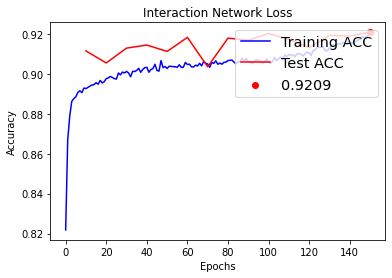

INFO:tensorflow:Assets written to: ./saved_objects/300_pixel_35_com/model/assets


INFO:tensorflow:Assets written to: ./saved_objects/300_pixel_35_com/model/assets


[[5690  346]
 [ 271 1491]]
Processing files: 1/140
Processing files: 2/140
Processing files: 3/140
Processing files: 4/140
Processing files: 5/140


/home/daniel/anaconda3/lib/python3.8/site-packages/radiomics/glcm.py:654: RuntimeWarning: invalid value encountered in sqrt
  MCC = numpy.sqrt(Q_eigenValue[:, :, -2])  # 2nd highest eigenvalue


Processing files: 6/140
Processing files: 7/140
Processing files: 8/140
Processing files: 9/140
Processing files: 10/140
Processing files: 11/140
Processing files: 12/140
Processing files: 13/140
Processing files: 14/140
Processing files: 15/140
Processing files: 16/140
Processing files: 17/140
Processing files: 18/140
Processing files: 19/140
Processing files: 20/140
Processing files: 21/140
Processing files: 22/140
Processing files: 23/140
Processing files: 24/140
Processing files: 25/140
Processing files: 26/140
Processing files: 27/140
Processing files: 28/140
Processing files: 29/140
Processing files: 30/140
Processing files: 31/140
Processing files: 32/140
Processing files: 33/140
Processing files: 34/140
Processing files: 35/140
Processing files: 36/140
Processing files: 37/140


/home/daniel/anaconda3/lib/python3.8/site-packages/radiomics/glcm.py:599: RuntimeWarning: invalid value encountered in sqrt
  imc2 = (1 - numpy.e ** (-2 * (HXY2 - HXY))) ** 0.5


Processing files: 38/140
Processing files: 39/140
Processing files: 40/140
Processing files: 41/140
Processing files: 42/140
Processing files: 43/140
Processing files: 44/140
Processing files: 45/140
Processing files: 46/140
Processing files: 47/140
Processing files: 48/140
Processing files: 49/140
Processing files: 50/140
Processing files: 51/140
Processing files: 52/140
Processing files: 53/140
Processing files: 54/140
Processing files: 55/140
Processing files: 56/140
Processing files: 57/140
Processing files: 58/140
Processing files: 59/140
Processing files: 60/140
Processing files: 61/140
Processing files: 62/140
Processing files: 63/140
Processing files: 64/140
Processing files: 65/140
Processing files: 66/140
Processing files: 67/140
Processing files: 68/140
Processing files: 69/140
Processing files: 70/140
Processing files: 71/140
Processing files: 72/140
Processing files: 73/140
Processing files: 74/140
Processing files: 75/140
Processing files: 76/140
Processing files: 77/140


/home/daniel/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_133 (Conv2D)             (None, 128, 128, 64) 640         input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_134 (Conv2D)             (None, 128, 128, 64) 36928       conv2d_133[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_28 (MaxPooling2D) (None, 64, 64, 64)   0           conv2d_134[0][0]                 
___________________________________________________________________________________________

/home/daniel/.local/lib/python3.8/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


30/30 [==============================] - 30s 967ms/step - loss: 0.1839 - iou: 0.4777 - val_loss: 0.1310 - val_iou: 0.5647

Epoch 00001: val_loss improved from inf to 0.13105, saving model to segm_ALL_.h5
[TensorShape([28685, None, 12]), TensorShape([28685, None, 1]), TensorShape([28685, None, 2])]
[TensorShape([7807, None, 12]), TensorShape([7807, None, 1]), TensorShape([7807, None, 2])]
(28685,) (7807,)
INFO:kgcnn: Updated model kwargs:
{'depth': 1,
 'gcn_args': {'activation': 'relu',
              'has_unconnected': True,
              'is_sorted': False,
              'normalize_by_weights': False,
              'pooling_method': 'mean',
              'units': 64,
              'use_bias': True},
 'input_embedding': {'edge': {'input_dim': 10, 'output_dim': 64},
                     'node': {'input_dim': 55, 'output_dim': 64}},
 'inputs': [{'dtype': 'float32',
             'name': 'node_attributes',
             'ragged': True,
             'shape': (None, 12)},
            {'dtype':

/home/daniel/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_14/gcn_6/pooling_weighted_local_edges_7/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_14/gcn_6/pooling_weighted_local_edges_7/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model_14/gcn_6/pooling_weighted_local_edges_7/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/daniel/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_14/gcn_6/gather_nodes_outgoing_7/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model_14/gcn_6/gather_nodes_outgoing_7/Reshape:0", shape=(None, 64), dtype=float32), 

897/897 - 3s - loss: 0.4267 - accuracy: 0.8350
Epoch 2/150
897/897 - 2s - loss: 0.2822 - accuracy: 0.8740
Epoch 3/150
897/897 - 2s - loss: 0.2608 - accuracy: 0.8818
Epoch 4/150
897/897 - 2s - loss: 0.2563 - accuracy: 0.8837
Epoch 5/150
897/897 - 2s - loss: 0.2499 - accuracy: 0.8860
Epoch 6/150
897/897 - 2s - loss: 0.2489 - accuracy: 0.8866
Epoch 7/150
897/897 - 2s - loss: 0.2417 - accuracy: 0.8917
Epoch 8/150
897/897 - 2s - loss: 0.2447 - accuracy: 0.8915
Epoch 9/150
897/897 - 2s - loss: 0.2415 - accuracy: 0.8912
Epoch 10/150
897/897 - 2s - loss: 0.2396 - accuracy: 0.8914 - val_loss: 0.2084 - val_accuracy: 0.9071
Epoch 11/150
897/897 - 2s - loss: 0.2397 - accuracy: 0.8929
Epoch 12/150
897/897 - 2s - loss: 0.2344 - accuracy: 0.8930
Epoch 13/150
897/897 - 2s - loss: 0.2354 - accuracy: 0.8948
Epoch 14/150
897/897 - 2s - loss: 0.2351 - accuracy: 0.8938
Epoch 15/150
897/897 - 2s - loss: 0.2350 - accuracy: 0.8952
Epoch 16/150
897/897 - 2s - loss: 0.2340 - accuracy: 0.8968
Epoch 17/150
897/89

897/897 - 2s - loss: 0.1845 - accuracy: 0.9166
Epoch 130/150
897/897 - 2s - loss: 0.1869 - accuracy: 0.9141 - val_loss: 0.1838 - val_accuracy: 0.9224
Epoch 131/150
897/897 - 2s - loss: 0.1862 - accuracy: 0.9168
Epoch 132/150
897/897 - 2s - loss: 0.1851 - accuracy: 0.9155
Epoch 133/150
897/897 - 2s - loss: 0.1832 - accuracy: 0.9169
Epoch 134/150
897/897 - 2s - loss: 0.1829 - accuracy: 0.9145
Epoch 135/150
897/897 - 2s - loss: 0.1834 - accuracy: 0.9175
Epoch 136/150
897/897 - 2s - loss: 0.1821 - accuracy: 0.9172
Epoch 137/150
897/897 - 2s - loss: 0.1815 - accuracy: 0.9164
Epoch 138/150
897/897 - 2s - loss: 0.1819 - accuracy: 0.9158
Epoch 139/150
897/897 - 2s - loss: 0.1815 - accuracy: 0.9168
Epoch 140/150
897/897 - 2s - loss: 0.1801 - accuracy: 0.9181 - val_loss: 0.1856 - val_accuracy: 0.9217
Epoch 141/150
897/897 - 2s - loss: 0.1799 - accuracy: 0.9183
Epoch 142/150
897/897 - 2s - loss: 0.1787 - accuracy: 0.9178
Epoch 143/150
897/897 - 2s - loss: 0.1787 - accuracy: 0.9181
Epoch 144/150
8

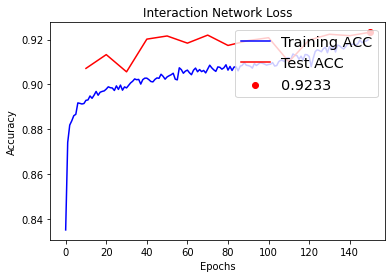

INFO:tensorflow:Assets written to: ./saved_objects/300_pixel_40_com/model/assets


INFO:tensorflow:Assets written to: ./saved_objects/300_pixel_40_com/model/assets


[[5725  319]
 [ 280 1483]]


In [6]:
for data_set in DATA_SET_DIR_NAMES:
    process_data_set(data_set)